# SSH Model: easy calculations using Kwant

In [2]:
## First some standar imports
import numpy as np
import matplotlib
import kwant
import kwant.continuum
from matplotlib import pyplot as plt
from ipywidgets import *
import tinyarray
%matplotlib inline

In [0]:
# Let's define the Pauli matrices
sigma_0 = tinyarray.array([[1, 0], [0, 1]])
sigma_x = tinyarray.array([[0, 1], [1, 0]])
sigma_y = tinyarray.array([[0, -1j], [1j, 0]])
sigma_z = tinyarray.array([[1, 0], [0, -1]])

##### - Let's start by defining the system


It is given by the tight binding Hamiltonian described in class:

\begin{equation}
    H = v \sum _{n = 1}^N |{n}><{n}|\otimes\sigma_x
    + w \sum_{n = 1}^{N-1} \left( |{n+1}><{n}| \otimes \frac{\sigma_x+ i \sigma_y}{2} + h.c.\right)~.
\end{equation}

In [6]:
def SSH_chain(L=None):
    lat = kwant.lattice.chain(norbs=2) # It is a chain with two orbitals
    if L is None: # This is for the bulk calculatins, we consider an inginite system with symmetry in the direction given by the vector [-1]
        syst = kwant.Builder(kwant.TranslationalSymmetry((-1,)))
        L = 1
    else: #Otherwise, we initialize a Builder without any symmetry
        syst = kwant.Builder()
    # The onsite contribution
    def onsite(site, v):
        return (v *(sigma_x))
    # we build the system with the former onsite term
    for x in range(L):
        syst[lat(x)] = onsite
    # Now we define the hoppings
    def hop(site1, site2, w):
        return (w*( sigma_x + 1j *sigma_y)/2)
    #and we implement such hoppings in the chain 
    syst[kwant.HoppingKind((1,), lat)] = hop
    return syst

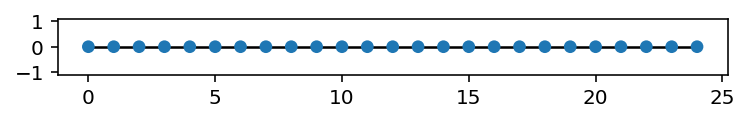

In [19]:
# Let's build a small system, with 25 sites
L = 25; 
syst = SSH_chain(L=L).finalized();
kwant.plot(syst);

#This is the density operator of the system, we will use it in the following for computing the wavefunctions
rho = kwant.operator.Density(syst) 

##### - Now, let's define the vector d(k)
\begin{equation}
    H (k) = d_0(k) \sigma_0 + \vec{d}(k) \cdot {\vec{\sigma}}~,
\end{equation}

In [29]:
# This second function is for the vector $d$ 
def d_func(k, params):
    v = params['v']
    w = params['w']
    return [0, v + w*np.cos(k), w*np.sin(k), 0]

## Bulk properties:

In [7]:
def plot_path(params):
    # The path of the vector d in the BZ is given by:
    ks = np.linspace(-np.pi, np.pi)
    ds = [d_func(k, params = params) for k in ks]
    # The bulk system is obtained setting the translational symmetry:
    syst_bulk = SSH_chain(L=None).finalized()
    # Just plot it all together, by on side the vecto d, by the other the bands of the bulk material
    fig = plt.figure(figsize=(6, 3))
    ax = fig.add_subplot(121); ax.set_aspect('equal');
    ax.set_xlabel(r'$d_x$'); ax.set_ylabel(r'$d_y$'); 
    ax.plot(0,0,'ko', markersize = 5, label= '(0,0)')
    if np.round(params['w'], 10) ==0:
        ax.plot(ds[0][1],ds[0][2],'o', markersize = 5, label= r'$\mathbf{d}(k)$')
    else:
        ax.plot(np.array(ds).T[1], np.array(ds).T[2], label= r'$\mathbf{d}(k)$', linewidth= 2);
    ax.grid(which = 'both'); ax.set_xlim(-2,2); ax.set_ylim(-2,2);
    ax.legend(loc = 'upper center')

    ax = fig.add_subplot(122)
    bands = kwant.plotter.bands(syst_bulk, params= params, ax = ax);
    ax.set_xlabel('k'); ax.set_ylabel('Energy'); 
    ax.set_title('v = {}, w = {}'.format(params['v'], params['w']))
    plt.tight_layout(w_pad=2.5);
    plt.show();


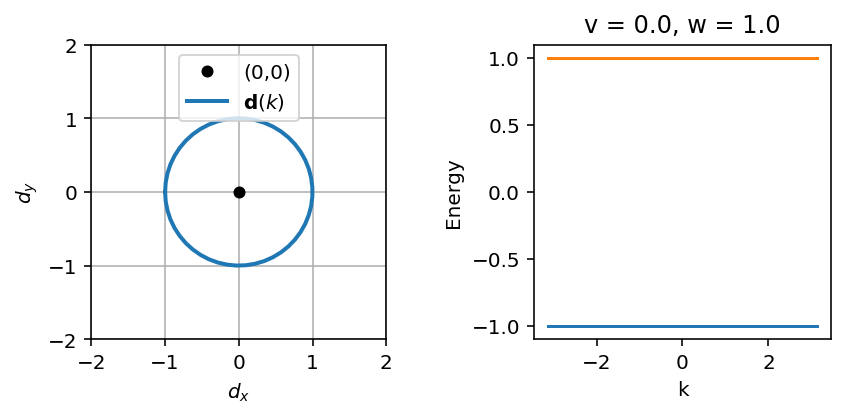

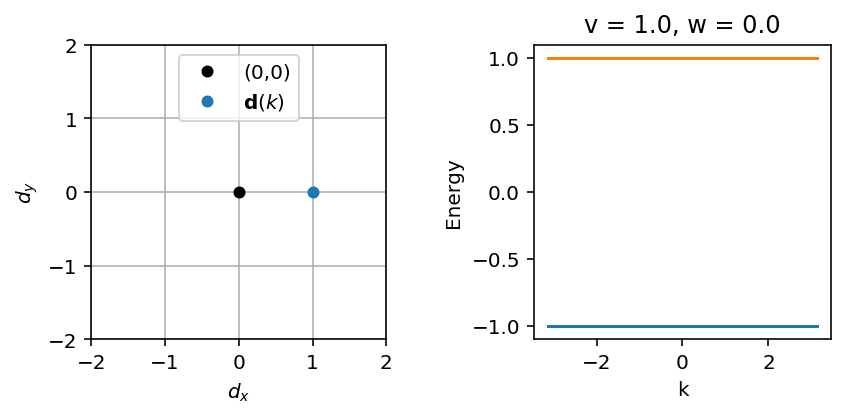

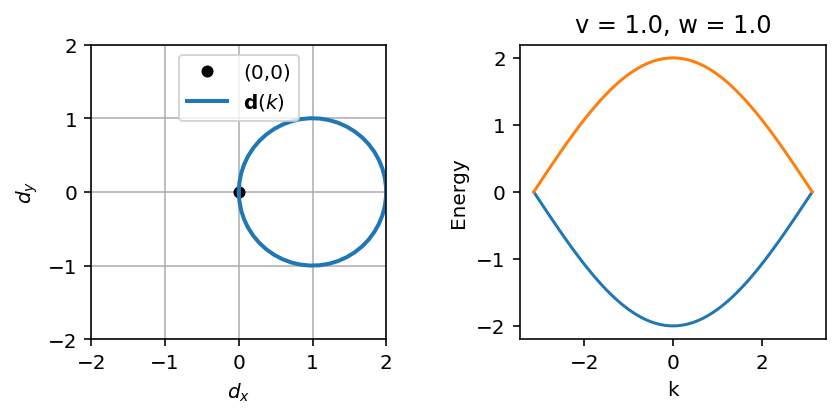

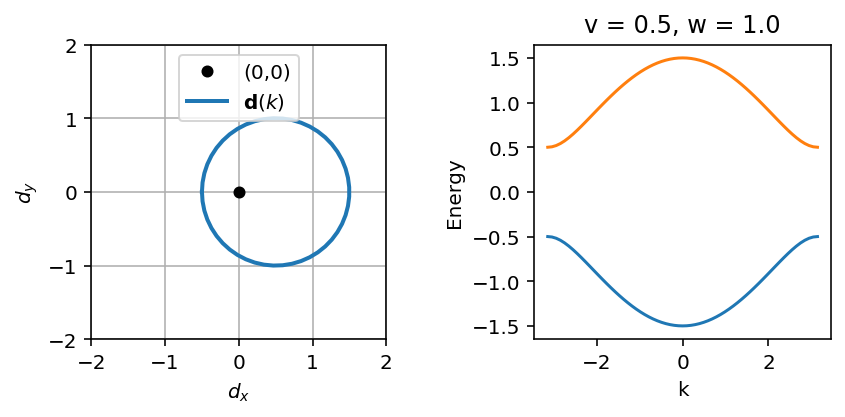

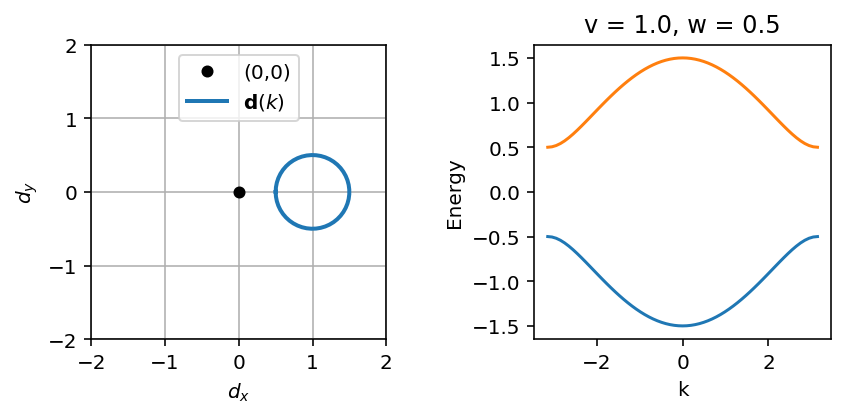

In [12]:
# Let's plot some representative values. 
params = dict(v= 0., w=1.)
plot_path(params)
params = dict(v= 1., w=0.)
plot_path(params)
params = dict(v= 1., w=1.)
plot_path(params)
params = dict(v= 0.5, w=1.)
plot_path(params)
params = dict(v= 1., w=0.5)
plot_path(params)

In [41]:
# In an interactive Plot:

def update_plot_path(v = 1., w = 1.):
    params = dict(v= v, w=w)
    plot_path(params)

interact(update_plot_path, v= widgets.FloatSlider(min=0.0, max=1.0, step=0.25, value=0) , w =widgets.FloatSlider(min=0.0, max=1.0, step=0.25, value=1.));

interactive(children=(FloatSlider(value=0.0, description='v', max=1.0, step=0.25), FloatSlider(value=1.0, desc…

#### Finite system: edge states
Now we fix the w=1 and let's see how the surface states arise in the finite system

In [42]:
# We diagonalize the prolem for a range of v = (0, 3.0)
vs = np.linspace(1e-14, 3, 21)
ws = np.ones((len(vs),1))
evs = []; evecs = []; 
for j in range(len(vs)):
    params = dict(v= vs[j], w= ws[j])
    ham = syst.hamiltonian_submatrix(params = params)
    ev, evec = np.linalg.eigh(ham)
    evs.append(ev); evecs.append(evec)

In [43]:
# A couple of functions for to plot the states
def plot_density(ev, evec, ax):
    j = [L, L-1, L+1, L-2]; x = np.arange(0, L); colors = ['red', 'red', 'gray', 'gray']; k = 0;
    for j in j:
        density = rho(evec[:,j])
        ax.fill_between(x, density, label = 'Energy ~ {}'.format(np.round(ev[j], 2)), color = colors[k], alpha = 0.6); k+= 1;
    plt.legend();
def plot_states(j=0):
    fig = plt.figure(figsize=(8, 4))
    ax1 = fig.add_subplot(121); 
    ax1.plot(vs, evs);
    ax1.axvline(x = vs[j], color = 'k');
    ax1.set_ylabel(r'Energy'); ax1.set_xlabel('v, (w = 1)'); 

    ax2 = fig.add_subplot(122); 
    plot_density(evs[j], evecs[j], ax= ax2)
    ax2.set_ylabel(r'$|\psi|^2$'); ax2.set_xlabel('x');
    plt.tight_layout(w_pad=2.5);
    plt.show();

We respresent the energies a function of the value of v. In the right hand side we plot the wavefunctions for the four lowers states in energy

In [44]:
interact(plot_states, j=widgets.IntSlider(min=0, max=len(vs)-1, step=1, value=0));

interactive(children=(IntSlider(value=0, description='j', max=20), Output()), _dom_classes=('widget-interact',…